# 하이퍼파라미터 튜닝

기본 모델 성능:
- LightGBM: ~0.798 F1-macro
- XGBoost: ~0.800 F1-macro

목표: 하이퍼파라미터 최적화로 0.815-0.830 달성

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import time

## 1. 데이터 로딩 및 전처리

In [5]:
train_df = pd.read_csv('../data/open/train.csv')

X = train_df.drop(columns=['ID', 'target'])
y = train_df['target']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"데이터 크기: {X_scaled.shape}")
print(f"\n클래스 분포:\n{y.value_counts().sort_index()}")

데이터 크기: (21693, 52)

클래스 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64


## 2. 하이퍼파라미터 탐색 공간 정의

### 주요 하이퍼파라미터 설명:

- **n_estimators**: 나무 개수 (많을수록 성능 좋지만 시간 오래 걸림)
- **max_depth**: 나무 깊이 (깊을수록 복잡한 패턴 학습, 과적합 위험)
- **learning_rate**: 학습률 (작을수록 천천히 정확하게 학습)
- **subsample**: 데이터 샘플링 비율 (과적합 방지)
- **colsample_bytree**: 피처 샘플링 비율 (과적합 방지)
- **reg_alpha, reg_lambda**: 정규화 강도 (과적합 방지)

## 3. LightGBM 하이퍼파라미터 튜닝

In [6]:
lgbm_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [4, 6, 8, 10, 12, -1],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'num_leaves': [31, 50, 70, 100, 150],
    'min_child_samples': [20, 30, 40, 50],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

lgbm_base = lgb.LGBMClassifier(
    device='gpu',
    random_state=42,
    verbose=-1
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='macro')

print("LightGBM 하이퍼파라미터 튜닝 시작...")
print(f"총 {50}개 조합 테스트 (5-Fold CV)")
print("예상 소요 시간: 30-60분\n")

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=lgbm_param_dist,
    n_iter=50,
    cv=skf,
    scoring=f1_scorer,
    random_state=42,
    # n_jobs=4,
    verbose=2
)

start_time = time.time()
lgbm_random_search.fit(X_scaled, y)
lgbm_elapsed = time.time() - start_time

print(f"\n완료! 소요 시간: {lgbm_elapsed/60:.2f}분")
print(f"최고 F1-macro 점수: {lgbm_random_search.best_score_:.6f}")
print(f"\n최적 하이퍼파라미터:")
for param, value in lgbm_random_search.best_params_.items():
    print(f"  {param}: {value}")

LightGBM 하이퍼파라미터 튜닝 시작...
총 50개 조합 테스트 (5-Fold CV)
예상 소요 시간: 30-60분

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, n_estimators=200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   6.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, n_estimators=200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, n_estimators=200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, n_estimators=200, num_leaves=31, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   5.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, n_estimators=200, num_leaves=31, reg_alpha=0.5, reg_

## 4. XGBoost 하이퍼파라미터 튜닝

In [7]:
xgb_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

xgb_base = xgb.XGBClassifier(
    tree_method='hist',
    device="cuda",
    objective='multi:softmax',
    num_class=len(y.unique()),
    random_state=42,
    verbosity=0
)

print("XGBoost 하이퍼파라미터 튜닝 시작...")
print(f"총 {50}개 조합 테스트 (5-Fold CV)")
print("예상 소요 시간: 30-60분\n")

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=skf,
    scoring=f1_scorer,
    random_state=42,
    # n_jobs=4,
    verbose=2
)

start_time = time.time()
xgb_random_search.fit(X_scaled, y)
xgb_elapsed = time.time() - start_time

print(f"\n완료! 소요 시간: {xgb_elapsed/60:.2f}분")
print(f"최고 F1-macro 점수: {xgb_random_search.best_score_:.6f}")
print(f"\n최적 하이퍼파라미터:")
for param, value in xgb_random_search.best_params_.items():
    print(f"  {param}: {value}")

XGBoost 하이퍼파라미터 튜닝 시작...
총 50개 조합 테스트 (5-Fold CV)
예상 소요 시간: 30-60분

Fitting 5 folds for each of 50 candidates, totalling 250 fits


sh: 0: getcwd() failed: No such file or directory


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0.5, reg_lambda=0.1, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=2

## 5. 결과 비교 및 시각화


최종 성능 비교
        Model  F1-Macro Score
LightGBM (기본)        0.798000
LightGBM (튜닝)        0.805234
 XGBoost (기본)        0.800000
 XGBoost (튜닝)        0.800142

LightGBM 개선: +0.72%
XGBoost 개선: +0.01%


/tmp/ipykernel_2175230/3435634776.py:25: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2175230/3435634776.py:25: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2175230/3435634776.py:25: UserWarning: Glyph 53916 (\N{HANGUL SYLLABLE TYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2175230/3435634776.py:25: UserWarning: Glyph 45789 (\N{HANGUL SYLLABLE NING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2175230/3435634776.py:25: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2175230/3435634776.py:25: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2175230/3435634776.py:25: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from font(s) DejaVu S

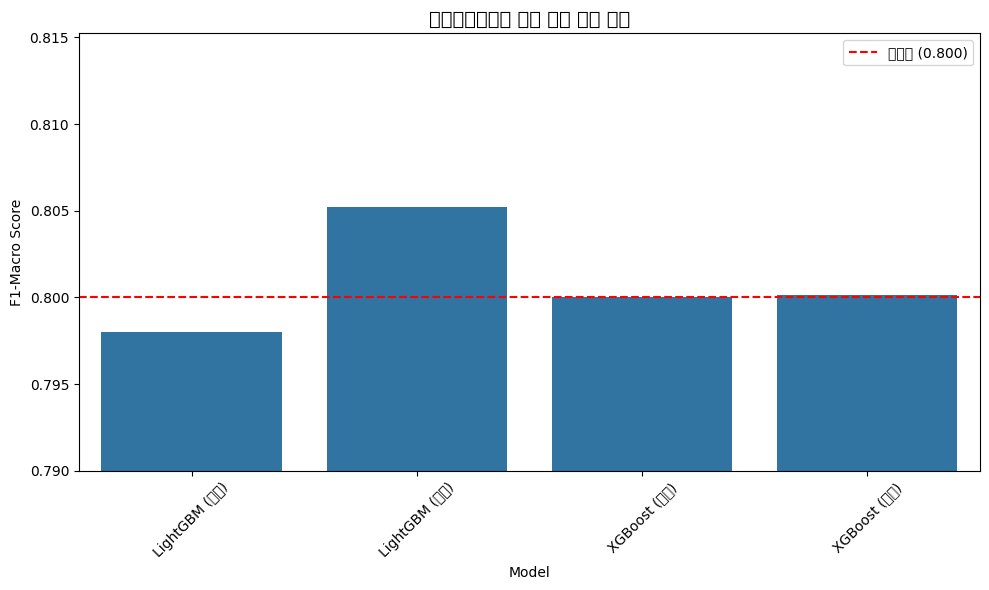

In [8]:
results_comparison = pd.DataFrame({
    'Model': ['LightGBM (기본)', 'LightGBM (튜닝)', 'XGBoost (기본)', 'XGBoost (튜닝)'],
    'F1-Macro Score': [0.798, lgbm_random_search.best_score_, 0.800, xgb_random_search.best_score_]
})

print("\n" + "="*60)
print("최종 성능 비교")
print("="*60)
print(results_comparison.to_string(index=False))

lgbm_improvement = (lgbm_random_search.best_score_ - 0.798) * 100
xgb_improvement = (xgb_random_search.best_score_ - 0.800) * 100

print(f"\nLightGBM 개선: +{lgbm_improvement:.2f}%")
print(f"XGBoost 개선: +{xgb_improvement:.2f}%")

plt.figure(figsize=(10, 6))
sns.barplot(data=results_comparison, x='Model', y='F1-Macro Score')
plt.axhline(y=0.800, color='r', linestyle='--', label='기준선 (0.800)')
plt.title('하이퍼파라미터 튜닝 전후 성능 비교', fontsize=14)
plt.ylabel('F1-Macro Score')
plt.ylim(0.79, max(results_comparison['F1-Macro Score']) + 0.01)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. 최적 모델로 예측 생성

In [9]:
best_model = lgbm_random_search.best_estimator_ if lgbm_random_search.best_score_ > xgb_random_search.best_score_ else xgb_random_search.best_estimator_
best_model_name = 'LightGBM' if lgbm_random_search.best_score_ > xgb_random_search.best_score_ else 'XGBoost'
best_score = max(lgbm_random_search.best_score_, xgb_random_search.best_score_)

print(f"최고 성능 모델: {best_model_name}")
print(f"CV F1-Macro Score: {best_score:.6f}")

test_df = pd.read_csv('../data/open/test.csv')
test_ids = test_df['ID']
X_test = test_df.drop(columns=['ID'])
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_scaled, y)
predictions = best_model.predict(X_test_scaled)

submission = pd.DataFrame({
    'ID': test_ids,
    'target': predictions
})

submission.to_csv('../outputs/submissions/submission_tuned.csv', index=False)
print("\n제출 파일 저장 완료: outputs/submissions/submission_tuned.csv")
print(f"\n예측 분포:\n{pd.Series(predictions).value_counts().sort_index()}")

최고 성능 모델: LightGBM
CV F1-Macro Score: 0.805234


/home/e7217/projects/dacon-236590/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



제출 파일 저장 완료: outputs/submissions/submission_tuned.csv

예측 분포:
0      819
1      669
2      416
3      939
4      730
5      456
6      700
7      463
8     1013
9      742
10     712
11     652
12    1249
13     674
14     708
15     766
16     591
17     711
18     676
19     611
20     707
Name: count, dtype: int64


## 7. 모델 저장

In [10]:
import joblib

joblib.dump(lgbm_random_search.best_estimator_, '../models/lgbm_tuned.pkl')
joblib.dump(xgb_random_search.best_estimator_, '../models/xgb_tuned.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

print("모델 저장 완료:")
print("  - models/lgbm_tuned.pkl")
print("  - models/xgb_tuned.pkl")
print("  - models/scaler.pkl")

모델 저장 완료:
  - models/lgbm_tuned.pkl
  - models/xgb_tuned.pkl
  - models/scaler.pkl
